# Fundus Examination

Tomasz Jankowiak 141235

Zuzanna Juszczak 141238

In [1]:
import io
from matplotlib import pylab as plt
import numpy as np
import cv2 as cv
from sklearn.feature_extraction import image
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from PIL import Image
from IPython.display import clear_output
import ipywidgets as widgets

In [2]:
def createConfusionMatrix(processed_image, result_image):
    TP, TN, FP, FN = 0, 0, 0, 0

    confusion_matrix_image = np.zeros((processed_image.shape[0], processed_image.shape[1], 3), np.uint8)
    
    for i in range(len(processed_image)):
        for j in range(len(processed_image[0])):
            
            if processed_image[i][j] == 0 and result_image[i][j] == False:
                TN += 1
            elif processed_image[i][j] == 0 and result_image[i][j] == True:
                FN += 1
                confusion_matrix_image[i][j] = (255, 0, 0)
            elif (processed_image[i][j] == 255 or processed_image[i][j] == True) and result_image[i][j] == False:
                FP += 1
                confusion_matrix_image[i][j] = (0, 155, 255)
            else:
                TP += 1
                confusion_matrix_image[i][j] = (255, 255, 255)
    
    return TP, TN, FP, FN, confusion_matrix_image

def calculateAccuracy(TP, TN, FP, FN):
    return (TP + TN) / (TP + TN + FP + FN)

def calculateSensitivity(TP, TN, FP, FN):
    return TP / (TP + FN)

def calculateSpecificity(TP, TN, FP, FN):
    return TN / (TN + FP)

def calculatePrecision(TP, TN, FP, FN):
    return TP / (TP + FP)

def calculateGMean(TP, TN, FP, FN):
    sensitivity = calculateSensitivity(TP, TN, FP, FN)
    specificity = calculateSpecificity(TP, TN, FP, FN)
    
    return np.sqrt(sensitivity * specificity)

def calculateFMeasure(TP, TN, FP, FN):
    precision = calculatePrecision(TP, TN, FP, FN)
    sensitivity = calculateSensitivity(TP, TN, FP, FN)
    
    return (2 * precision * sensitivity) / (precision + sensitivity)

def displayStatisticalAnalysis(processed_image, result_image):
    TP, TN, FP, FN, confusion_matrix_image = createConfusionMatrix(processed_image, result_image)
    
    print("Accuracy:    ", calculateAccuracy(TP, TN, FP, FN))
    print("Sensitivity: ", calculateSensitivity(TP, TN, FP, FN))
    print("Specificity: ", calculateSpecificity(TP, TN, FP, FN))
    print("Precision:   ", calculatePrecision(TP, TN, FP, FN))
    print("G-Mean:      ", calculateGMean(TP, TN, FP, FN))
    print("F-Measure:   ", calculateFMeasure(TP, TN, FP, FN))
    
    return confusion_matrix_image

In [3]:
class ImageBuilder:
    def __init__(self):
        self.image = None
        
    def loadImage(self, image):
        self.image = image
        return self
    
    def extractGreenChannel(self):
        b, g, r = cv.split(self.image)
        self.image = g
        return self
    
    def applyClahe(self):
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        self.image = clahe.apply(self.image)
        return self

    def increaseContrast(self):
        self.image = cv.addWeighted(self.image, 2, self.image, 0, 0)
        return self

    def toGray(self):
        self.image = cv.cvtColor(self.image, cv.COLOR_RGB2GRAY)
        return self

    def medianBlur(self):
        self.image = cv.medianBlur(self.image, 5)
        return self
    
    def adaptiveThreshold(self):
        self.image = cv.adaptiveThreshold(\
                    self.image, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 13, 2)
        return self

    def denoise(self):
        self.image = cv.fastNlMeansDenoising(self.image, None, 3, 7, 21)
        return self
    
    def denoiseByContours(self):
        mask = np.ones([self.image.shape[0], self.image.shape[1]], dtype="uint8") * 255
        contours, _ = cv.findContours(self.image.copy(), cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            if cv.contourArea(cnt) <= 200:
                cv.drawContours(mask, [cnt], -1, 0, -1)
        self.image = cv.bitwise_and(self.image, self.image, mask=mask)
        return self

    def applyOpening(self, k):
        self.image = cv.morphologyEx(self.image, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE, (k, k)), iterations=1)
        return self

    def applyClosing(self, k):
        self.image = cv.morphologyEx(self.image, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE, (k, k)), iterations=1)
        return self

    def build(self):
        return self.image

In [4]:
def extractPatches(img, patch_size):
    return image.extract_patches_2d(img, patch_size)

def calculateHuMoments(patch):
    return cv.HuMoments(cv.moments(patch)).flatten() 

def calculateVariance(patch):
    return np.sqrt(np.var(patch))

def calculateMean(patch):
    return np.mean(patch)

def getMiddlePixel(patch, patch_size):
    return patch[patch_size[0] // 2][patch_size[1] // 2]

def createFeaturesDataset(processed_image, patch_size = (5, 5)):
    max_y, max_x = processed_image.shape
    padding = patch_size[0] // 2  
    padded_image = np.zeros((max_y + 2 * padding, max_x + 2 * padding))
    padded_image[padding:-padding, padding:-padding] = processed_image
    
    processed_patches = extractPatches(padded_image, patch_size)    
    x = [] 
    
    for i in range(len(processed_patches)):
        patch = processed_patches[i]

        mean = calculateMean(patch)
        variance = calculateVariance(patch)
        middle_pixel = getMiddlePixel(patch, patch_size)   
        
        x.append(np.concatenate((mean, variance, middle_pixel), axis = None))
    
    return x

def createDataset(processed_image, result_image, patch_size = (5, 5), step = 10):
    processed_patches = extractPatches(processed_image, patch_size)
    result_patches = extractPatches(result_image, patch_size)
    
    x = []
    y = []
    
    for i in range(0, len(processed_patches), step):
        patch = processed_patches[i]
        
        mean = calculateMean(patch)
        variance = calculateVariance(patch)
        middle_pixel = getMiddlePixel(patch, patch_size)
        
        x.append(np.concatenate((mean, variance, middle_pixel), axis = None))
        y.append(result_patches[i][patch_size[0] // 2][patch_size[1] // 2]) 
    
    return x, y

def createClassifier(processed_image, result_image):
    x, y = createDataset(processed_image, result_image)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=4)
    
    undersample = RandomUnderSampler(sampling_strategy = 0.2)
    x_train_undersample, y_train_undersample = undersample.fit_resample(x_train, y_train)

    knn = KNeighborsClassifier(n_neighbors = 11)
    knn.fit(x_train_undersample, y_train_undersample)
    
#     y_pred = knn.predict(x_test)
#     print(confusion_matrix(y_test, y_pred))
    
    return knn
 
def preprocessImage(input_image):    
    input_image = cv.cvtColor(input_image, cv.COLOR_RGB2GRAY)
    input_image = cv.fastNlMeansDenoising(input_image, None, 3, 7, 21)
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    input_image = clahe.apply(input_image)
    
    return input_image

def classifyImage(input_image, result_image, knn, patch_size = (5, 5)):  
    input_image = preprocessImage(input_image)
    x_test = createFeaturesDataset(input_image)
    
    return knn.predict(x_test).reshape(result_image.shape)

In [5]:
def displayImages(inputImage, processedImage, result, confusion_matrix_image):
    fig = plt.figure(figsize=(8, 8), dpi=80)   
    
    ax = fig.add_subplot(221)
    ax.set_title('Obraz wejściowy')
    ax.imshow(inputImage, cmap = 'gray')
    ax.axis('off')
    
    ax = fig.add_subplot(222)
    ax.set_title('Maska ekspercka')
    ax.imshow(result, cmap = 'gray')
    ax.axis('off')
    
    ax = fig.add_subplot(223)
    ax.set_title('Nasz wynik')
    ax.imshow(processedImage, cmap = 'gray')
    ax.axis('off')
    
    ax = fig.add_subplot(224)
    ax.set_title('Macierz pomyłek')
    ax.imshow(confusion_matrix_image, cmap = 'gray')
    ax.axis('off')
    
    plt.savefig('output1.png')

In [6]:
def imageProcessing(input_image, expected_result_image):    
    '''przetwarzanie obrazu'''
        
    processed_image = ImageBuilder()\
                    .loadImage(input_image.copy())\
                    .denoise()\
                    .increaseContrast()\
                    .extractGreenChannel()\
                    .applyClahe()\
                    .applyOpening(5)\
                    .applyClosing(5)\
                    .adaptiveThreshold()\
                    .denoiseByContours()\
                    .applyClosing(5)\
                    .build()
       
    confusion_matrix_image = displayStatisticalAnalysis(processed_image, expected_result_image)
    displayImages(input_image, processed_image, expected_result_image, confusion_matrix_image)

In [7]:
def classifierProcessing(input_image, expected_result_image, classifier_input, classifier_result):    
    '''klasyfikator KNN'''               
    
    classifier_processed_image = preprocessImage(classifier_input)
    
    knn = createClassifier(classifier_processed_image, classifier_result)
    knn_result_image = classifyImage(input_image, expected_result_image, knn)
    
    knn_confusion_matrix_image = displayStatisticalAnalysis(knn_result_image, expected_result_image)
    displayImages(input_image, knn_result_image, expected_result_image, knn_confusion_matrix_image)

In [8]:
input_imageUpload = widgets.FileUpload(accept='image/*',
                                       multiple=False)

expected_result_imageUpload = widgets.FileUpload(accept='image/*',
                                                 multiple=False)

classifier_input_imageUpload =  widgets.FileUpload(accept='image/*',
                                                   multiple=False)

classifier_expected_result_imageUpload =  widgets.FileUpload(accept='image/*',
                                                             multiple=False)

image_processing_checkbox = widgets.Checkbox(value=False)
classifier_processing_checkbox = widgets.Checkbox(value=False)

display_box = widgets.HBox(
    [widgets.VBox([widgets.Label('Input image'), 
                   widgets.Label('Expected result image'),
                   widgets.Label('Classifier input image'),
                   widgets.Label('Classifier expected result'),
                   widgets.Label('Use image processing'), 
                   widgets.Label('Use classifier processing')]), 
     widgets.VBox([input_imageUpload, 
                   expected_result_imageUpload,
                   classifier_input_imageUpload,
                   classifier_expected_result_imageUpload,
                   image_processing_checkbox, 
                   classifier_processing_checkbox])
    ])

Button(description='Process image', style=ButtonStyle())

Output()

Output()

Accuracy:     0.9361726309642976
Sensitivity:  0.6761306720490394
Specificity:  0.9556680173288273
Precision:    0.5334536532427395
G-Mean:       0.8038385775840278
F-Measure:    0.5963773992971074


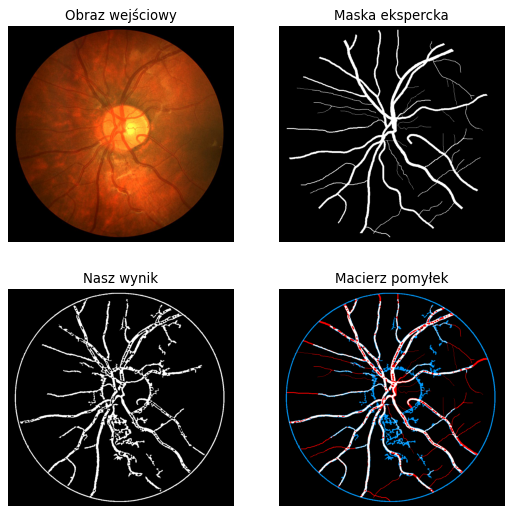

In [11]:
def main():
    display(display_box)
    
    process_button = widgets.Button(description='Process image')    
    output = widgets.Output()
    output2 = widgets.Output()
    display(process_button, output, output2)
        
    def onProcessButton(b):
        with output:
            for uploaded_filename in input_imageUpload.value:
                clear_output(wait=True)
                content = input_imageUpload.value[uploaded_filename]['content']
                input_image = Image.open(io.BytesIO(content))
                input_image = np.asarray(input_image)

            for uploaded_filename in expected_result_imageUpload.value:
                clear_output(wait=True)
                content = expected_result_imageUpload.value[uploaded_filename]['content']
                expected_result = Image.open(io.BytesIO(content))
                expected_result = np.asarray(expected_result)
            
        if image_processing_checkbox.value:
            imageProcessing(input_image, expected_result)
            
        if classifier_processing_checkbox.value:
            with output:
                for uploaded_filename in classifier_input_imageUpload.value:
                    clear_output(wait=True)
                    content = classifier_input_imageUpload.value[uploaded_filename]['content']
                    classifier_input = Image.open(io.BytesIO(content))
                    classifier_input = np.asarray(classifier_input)

                for uploaded_filename in classifier_expected_result_imageUpload.value:
                    clear_output(wait=True)
                    content = classifier_expected_result_imageUpload.value[uploaded_filename]['content']
                    classifier_expected_result = Image.open(io.BytesIO(content))
                    classifier_expected_result = np.asarray(classifier_expected_result)
                    
            classifierProcessing(input_image, expected_result, classifier_input, classifier_expected_result)
    
    process_button.on_click(onProcessButton)
            
if __name__ == '__main__':
    main()